In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data=pd.read_csv("./breast-cancer.csv")

diagnosis = {'M': 1, 'B': 0}
data['diagnosis'] = data['diagnosis'].map(diagnosis)
data=data.sample(frac=1)

train_data=data.iloc[0:80*len(data)//100]
test_data=data.iloc[80*len(data)//100:]
test_data_answers=test_data[["id","diagnosis"]]
test_data=test_data.loc[:,test_data.columns != "diagnosis"]

./breast-cancer.csv
./breastCancer.ipynb
./breastCancerRandomForest.ipynb
./predictions.csv
./submission.csv
./test.csv
./test70.csv
./test80.csv
./train.csv
./train20.csv
./train30.csv


In [12]:
train_data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
295,891923,0,13.77,13.27,88.06,582.7,0.09198,0.06221,0.01063,0.01917,...,14.67,16.93,94.17,661.1,0.1170,0.1072,0.03732,0.05802,0.2823,0.06794
494,914102,0,13.16,20.54,84.06,538.7,0.07335,0.05275,0.01800,0.01256,...,14.50,28.46,95.29,648.3,0.1118,0.1646,0.07698,0.04195,0.2687,0.07429
277,8911670,1,18.81,19.98,120.90,1102.0,0.08923,0.05884,0.08020,0.05843,...,19.96,24.30,129.00,1236.0,0.1243,0.1160,0.22100,0.12940,0.2567,0.05737
468,9113538,1,17.60,23.33,119.00,980.5,0.09289,0.20040,0.21360,0.10020,...,21.57,28.87,143.60,1437.0,0.1207,0.4785,0.51650,0.19960,0.2301,0.12240
156,8711202,1,17.68,20.74,117.40,963.7,0.11150,0.16650,0.18550,0.10540,...,20.47,25.11,132.90,1302.0,0.1418,0.3498,0.35830,0.15150,0.2463,0.07738


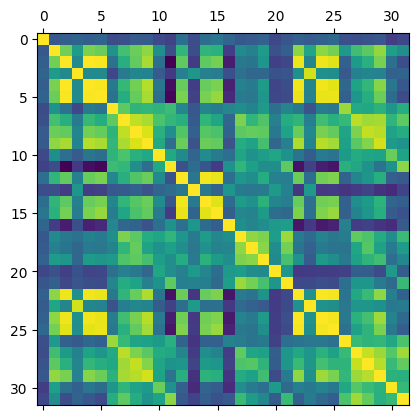

C:\Users\alexy\AppData\Local\Temp\ipykernel_14640\363462781.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(to_drop, axis=1, inplace=True)


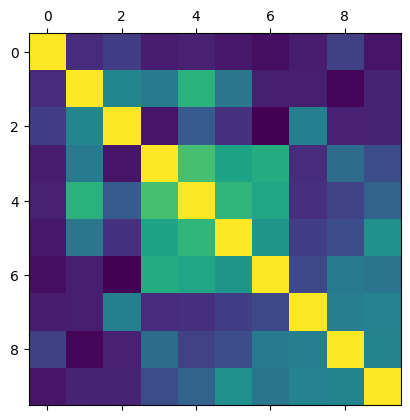

In [13]:
# Find highly correlated columns and remove then for Naive Bayes approach

import matplotlib.pyplot as plt


correlation=train_data.corr().abs()

plt.matshow(train_data.corr())
plt.show()

upper = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))

correlationCoefficent=0.7

to_drop = [column for column in upper.columns if any(upper[column] > correlationCoefficent) and column!="diagnosis"]

train_data.drop(to_drop, axis=1, inplace=True)




plt.matshow(train_data.corr())
plt.show()


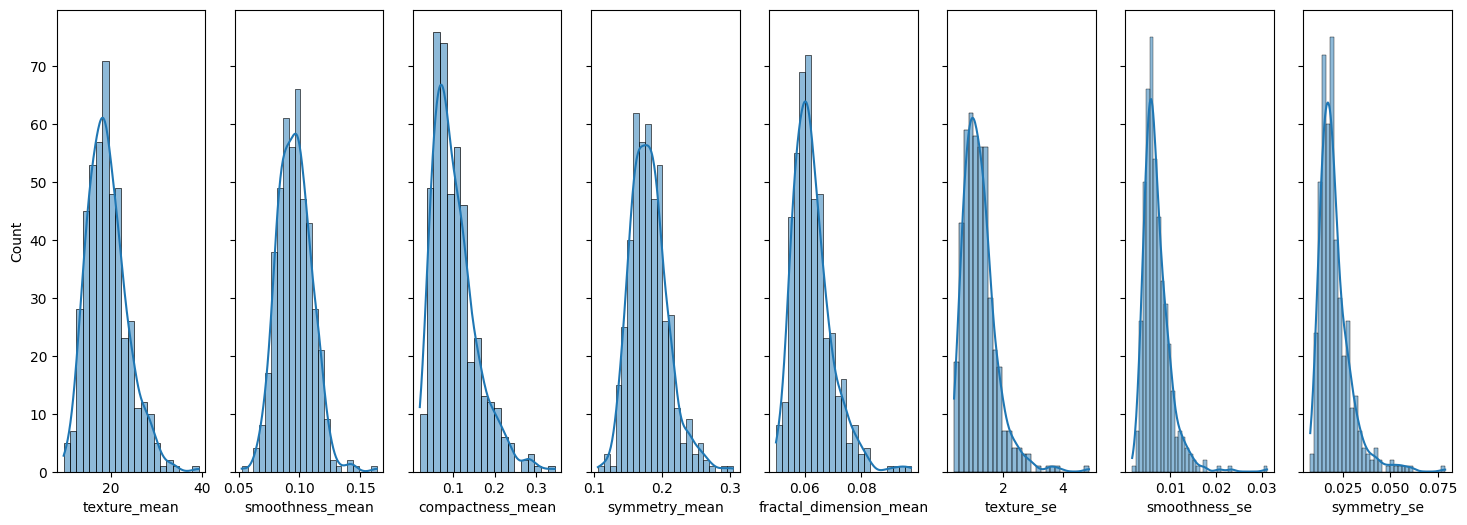

In [14]:
features=[column for column in train_data.columns if not (column=="id" or column=="diagnosis")]
fig, axes = plt.subplots(1, len(features), figsize=(18, 6), sharey=True)
for i in range(len(features)):
    sns.histplot(train_data, ax=axes[i], x=features[i], kde=True)

In [15]:
def calculatePy(y):
    malignant=len(train_data.loc[train_data.diagnosis==1]["diagnosis"])
    probability=np.float64(malignant/len(train_data))
    if y==1:
        return probability
    else:
        return 1-probability

def calculateXforY(column,x,y):
    df=train_data.loc[train_data.diagnosis==y][["diagnosis",column]]
    std=df[column].std()
    mean=df[column].mean()

    return (1/(np.sqrt(2*np.pi)*std))* np.exp(-((x-mean)**2 / (2*std**2)))


    # return len(desired)/len(df)


In [16]:
print(type(calculatePy(0)))

<class 'numpy.float64'>


In [17]:
def predictNaiveBayes(features,featureValues):
    yZero=calculatePy(0)
    yOne=calculatePy(1)
    for i in range(len(features)):
        if features.values[i] in train_data.columns:
            yZero*=calculateXforY(features.values[i],featureValues.values[i],0)
            yOne*=calculateXforY(features.values[i],featureValues.values[i],1)
            

    if yOne > yZero:
        return 1
    else:
        return 0

In [18]:
featuresTest=test_data.columns

print(predictNaiveBayes(featuresTest,test_data.iloc[0]))

1


In [19]:
predictions=pd.DataFrame(columns=['id','prediction'])

for i in range(len(test_data)):
    predictions.loc[i] =[int(test_data.iloc[i].values[0]),int(predictNaiveBayes(featuresTest,test_data.iloc[i]))]
    
predictions.to_csv('predictions.csv', index=False)
predictions.head()

,id,prediction
0,8611792,1
1,86409,1
2,891936,0
3,915664,0
4,926125,1


In [20]:
correct=0
for i in range(len(predictions)):
    if predictions.iloc[i].values[1]==test_data_answers.iloc[i].values[1]:
        correct+=1


print("Correct diagnosis: "+str(correct))
print("Total: "+ str(len(test_data)))

Correct diagnosis: 87
Total: 114
